<h1 style="color:gold">Ex 6: Grover's Algorithm</h1>


Consider f(x) being a query to any kind of search-space, if f(x)=1 then x is the solution to our search, be it either an index in a data-base or the input to a more complex function.
The x for which f(x)=1 is by convention called ω


In [42]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit.library import GroverOperator, MCMT, ZGate, XGate

import math as m
import matplotlib
import random

Input -> Grover -> oracle-check -> Result

In [43]:
# Cuz MCMT() create some c3z gates which cannot be executed

def initial_controls(circuit, gate, controls: list, targets: list, ancilas: list, depth: int):
    """
    Call with depth set to 0
    """
    ctrl_len = len(controls)
    anc_len = len(ancilas)

    if (ctrl_len - depth == 2):
        if (gate == 'x'):
            circuit.mcx([controls[0], controls[1]], ancilas[0])
        elif (gate == 'z'):
            circuit.cz([controls[0], controls[1]], ancilas[0])
    else:
        initial_controls(circuit, gate, controls, targets, ancilas, depth + 1)
        # Add Control on a new control-qbit and a previously used ancila
        if (gate == 'x'):
            circuit.mcx([controls[ctrl_len - depth - 1], ancilas[anc_len- depth - 2]], ancilas[anc_len- depth - 1])
        elif (gate == 'z'):
            circuit.mcz([controls[ctrl_len - depth - 1], ancilas[anc_len- depth - 2]], ancilas[anc_len- depth - 1])

def reverse_controls(circuit, gate, controls: list, targets: list, ancilas: list, depth: int):
    """
    Call with depth set to 0
    """
    ctrl_len = len(controls)
    anc_len = len(ancilas)

    if (ctrl_len - depth == 2):
        if (gate == 'x'):
            circuit.mcx([controls[0], controls[1]], ancilas[0])
        elif (gate == 'z'):
            circuit.mcz([controls[0], controls[1]], ancilas[0])
    else:
        # Add Control on a new control-qbit and a previously used ancila
        if (gate == 'x'):
            circuit.mcx([controls[ctrl_len - depth - 1], ancilas[anc_len- depth - 2]], ancilas[anc_len- depth - 1])
        if (gate == 'z'):
            circuit.mcz([controls[ctrl_len - depth - 1], ancilas[anc_len- depth - 2]], ancilas[anc_len- depth - 1])
        reverse_controls(circuit, gate, controls, targets, ancilas, depth + 1)

def decompose_some_large_gate(circuit, gate, controls: list, targets: list, ancilas: list):
    if (len(targets) != 1 or len(controls) < 2): # Not dealing with this right now
        raise ValueError(msg="Not supported")

    initial_controls(circuit, gate, controls, targets, ancilas, 0)
    circuit.barrier()
    if (gate == 'x'):
        circuit.cx(ancilas[len(ancilas) - 1], targets[0])
    elif (gate == 'z'):
        circuit.cz(ancilas[len(ancilas) - 1], targets[0])
    circuit.barrier()
    reverse_controls(circuit, gate, controls, targets, ancilas, 0)

In [44]:
def grover_oracle(oracle: QuantumCircuit, marked_states: list[str], num_qubits):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in the bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        if len(zero_inds) == 0:
            continue
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        oracle.x(zero_inds)
        oracle.barrier()
        oracle.compose(MCMT(ZGate(), num_qubits - 1, 1).decompose(), inplace=True) # Produces c4z gates that cannot be executed
        # decompose_some_large_gate(oracle, 'z', [c for c in range(num_qubits) if c != zero_inds], [zero_inds], ranges[2]) # Doesn't work for z gates
        oracle.barrier()
        oracle.x(zero_inds)
    return oracle

In [45]:
def apply_diffusion_operator(oracle, num_qubits, ranges):
    n = oracle.num_qubits
    n_range = range(n)

    diffused = oracle.copy()
    diffused.h(n_range)
    diffused.x(n_range)

    diffused.h(n - 1)
    # decompose_some_large_gate(diffused, 'x', ranges[0], ranges[1], ranges[2])
    diffused.compose(MCMT(XGate(), num_qubits - 1, 1).decompose(), inplace=True)
    diffused.h(n - 1)

    diffused.x(n_range)
    diffused.h(n_range)
    return diffused

In [46]:
marked = ["0000", "1000", "1001", "1010"]
for s in marked:
    if len(s) != len(marked[0]):
        raise ValueError(msg="Error")

nqbits = len(marked[0])
total_qbits = nqbits
total_qbits += nqbits - 1 # If using Ancilas
print(f"nqbits: {nqbits}")

###########################################3
### HOT-GARBAGE
ctrl = QuantumRegister(nqbits - 1, 'control')
target = QuantumRegister(1, 'target')
ancilas = QuantumRegister(nqbits - 2, 'ancilas')
c_range = [c for c in range(nqbits - 1)]
t_range = [nqbits]
a_range = [c + nqbits for c in range(nqbits - 2)]
ranges = (c_range, t_range, a_range)
print(f"total_qbits: {nqbits + nqbits - 1}, c: {c_range}, a: {a_range}")
oracle = QuantumCircuit(ctrl, target, ancilas) # 4 control 1 target 3 ancilas
###########################################3

# oracle = QuantumCircuit(nqbits)
grover_oracle(oracle, marked, nqbits)
oracle.barrier()
# oracle.draw() # Just way too big to draw

nqbits: 4
total_qbits: 7, c: [0, 1, 2], a: [4, 5]


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=6, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'control'), 0), Qubit(QuantumRegister(3, 'control'), 1), Qubit(QuantumRegister(3, 'control'), 2), Qubit(QuantumRegister(1, 'target'), 0), Qubit(QuantumRegister(2, 'ancilas'), 0), Qubit(QuantumRegister(2, 'ancilas'), 1)), clbits=())

The diffusion reverse the bit-state changes that the oracle might made to Q, but it keeps the phase unchanged

In [47]:
grover_operator = apply_diffusion_operator(oracle, nqbits, ranges)
# grover_operator = GroverOperator(oracle).decompose()
grover_operator.barrier()
# grover_operator.draw()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=6, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'control'), 0), Qubit(QuantumRegister(3, 'control'), 1), Qubit(QuantumRegister(3, 'control'), 2), Qubit(QuantumRegister(1, 'target'), 0), Qubit(QuantumRegister(2, 'ancilas'), 0), Qubit(QuantumRegister(2, 'ancilas'), 1)), clbits=())

Now create the grover circuit around the grover operator

In [48]:
N = 2**nqbits
n_range = range(nqbits)

# s is the number of solution
# N is the number of state
# t is the optimal iteration count
# p is the probability of correct measurment

s = -1 #default
s = len(marked)
if (s > 0): # If we know the number of solutions: s
    theta = m.asin(m.sqrt(s / N))
    t = m.floor(m.pi / (4 * theta))
    p = m.sin((2 * t + 1) * theta) ** 2
    print(f"Optimal iteration count: t = {t}, with probability of success p={p:0.6f}")
else: # Otherwise pick t at random in a this rangeL {1, pi*sqrt(N)/4}
    t = random.randrange(1, m.floor(m.pi*m.sqrt(N)/4), 1)
    print(f"Number of solutions not known, picking random: t = {t}, p is at least 0.4")

# Build the circuit and apply t times the gover-operation
grover_circuit = QuantumCircuit(total_qbits, nqbits)
grover_circuit.h(n_range) # Set the whole circuit in an undefined state

for _ in range(t):
    grover_circuit.compose(grover_operator, inplace=True)

grover_circuit.measure(n_range, n_range)
# grover_circuit.draw()


Optimal iteration count: t = 1, with probability of success p=1.000000


## Run it on simulator

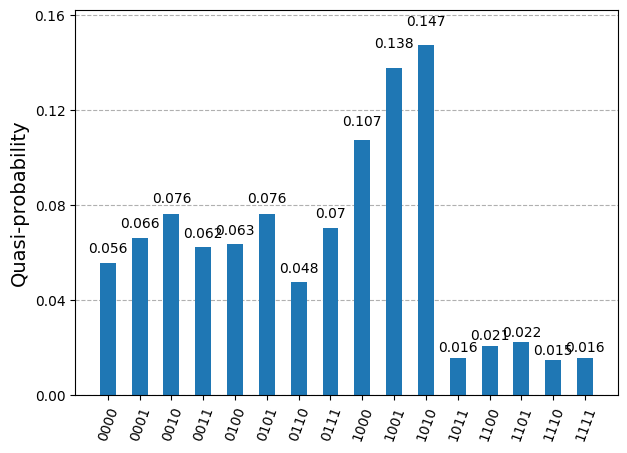

In [49]:
quasm_sim = AerSimulator()
circtui_aer = qiskit.transpile(grover_circuit, backend=quasm_sim)

counts = quasm_sim.run(grover_circuit).result().get_counts()
qiskit.visualization.plot_distribution(counts)

## Run it on a real Quantum-Computer

In [51]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
print(f"Runing simulation on: {backend.name}")

Runing simulation on: ibm_brisbane


In [52]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(grover_circuit)
circuit_isa.depth()
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

795

In [53]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 500
job = sampler.run([circuit_isa])
print(f"Job_id: {job.job_id()}")

Job_id: cvpxt1855th0008rqbbg


In [55]:
service = QiskitRuntimeService()
# 3 bits, oracle:["011", "100"], 100 shots
# job = service.job('cvp1syq20wjg008q0w8g')

# ERROR :/, circuit is 741,699 depth, it is best contained abot not much more than a thousand
# 12 bits, oracle:["000000000000", "000000100000", "000000100001", "000000100010"], 250 shots
# job = service.job('cvpxcxk20wjg008q2f80')

#
# 4bits, oracle:["0000", "1000", "1001", "1010"], 500 shots:
# job = service.job('cvpxt1855th0008rqbbg')

print(f"Job status: {job.status()}")

Job status: QUEUED


In [ ]:
result = job.result()
dist = result[0].data.meas.get_counts()
qiskit.visualization.plot_distribution(dist)